A useful fragmentation scheme

(1) Degen, J.; Wegscheid-Gerlach, C.; Zaliani, A.; Rarey, M. On the Art of Compiling and Using “Drug-Like” Chemical Fragment Spaces. ChemMedChem 2008, 3 (10), 1503–1507.


In [1]:
from rdkit import Chem
from rdkit.Chem import rdDepictor
rdDepictor.SetPreferCoordGen(True)
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem import BRICS
import rdkit
print(rdkit.__version__)

2025.03.5


# BRICS Basics

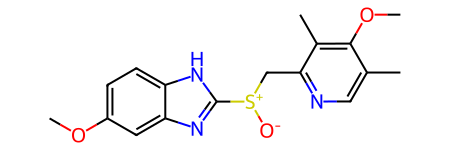

In [2]:
esomeprazole = Chem.MolFromSmiles('COc1ccc2[nH]c([S+]([O-])Cc3ncc(C)c(OC)c3C)nc2c1')
rdDepictor.Compute2DCoords(esomeprazole)
esomeprazole

In [3]:
pieces = BRICS.BRICSDecompose(esomeprazole)
pieces

{'[14*]c1ncc(C)c([16*])c1C',
 '[3*]OC',
 '[8*]C[S+]([O-])c1nc2cc([16*])ccc2[nH]1'}

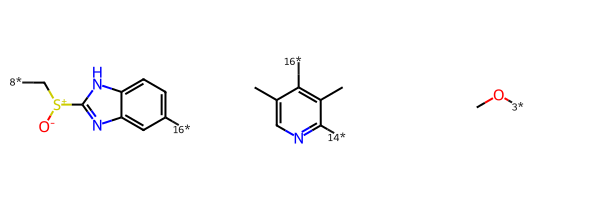

In [4]:
Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in pieces])

The atom environments and connection rules can be found in Scheme 2 of the BRICS paper:
![BRICS connection rules](https://chemistry-europe.onlinelibrary.wiley.com/cms/asset/797b1262-e8d9-42ad-b6b1-ba85878a35de/msch002.gif)

Note that the RDKit BRICS implementation does not contain a definition of L2, a three connected N with a lone pair. We incorporated that with L5 in a more general definition of amine. In the RDKit implementation L5 can connect with L1, L4, L12, L13, L14, L15, and L16. We also added a few additional connection definitions.
The actual SMARTS used in the RDKit can be found in [MolFragmenter.cpp](https://github.com/rdkit/rdkit-orig/blob/57058c886a49cc597b0c40641a28697ee3a57aee/Code/GraphMol/ChemTransforms/MolFragmenter.cpp#L104) along with the and the [connection rules](https://github.com/rdkit/rdkit-orig/blob/57058c886a49cc597b0c40641a28697ee3a57aee/Code/GraphMol/ChemTransforms/MolFragmenter.cpp#L205). There is also a Python version of the definitions in [BRICS.py](https://github.com/rdkit/rdkit-orig/blob/master/rdkit/Chem/BRICS.py), but this is no longer used and may not exactly the match the C++ implementation.

The RDKit's BRICS implementation includes the ability to create new molecules by stitching fragments together according to the connection rules above. Here's an illustration of that showing all the molecules that can be formed by combining the three fragments from esomeprazole using the BRICS connection rules with a maximum enumeration depth of 2:

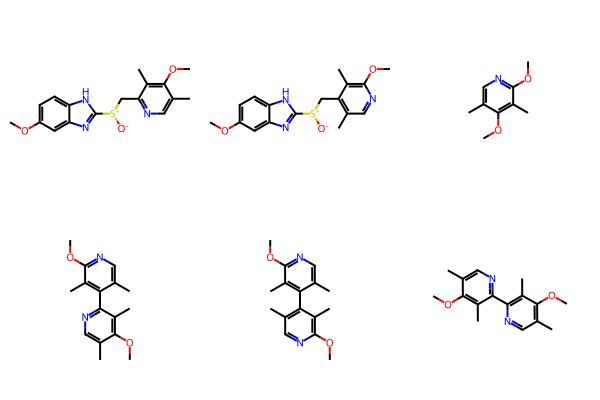

In [5]:
piecems = [Chem.MolFromSmiles(smi) for smi in pieces]
builder = BRICS.BRICSBuild(piecems, maxDepth=2, scrambleReagents=False)
ms = list(builder)
Draw.MolsToGridImage(ms)


# Enumerating a larger set of molecules

Here I grab the ChEMBL molecules that were most similar to esomeprazole, fragment them together with esomeprazole, and then explore some of the resulting molecules.

## Aside: grabbing similar molecules from ChEMBL

Here's the query I executed and the results returned:
```
chembl_35=# select chembl_id,m,similarity from get_mfp2_neighbors('COc1ccc2[nH]c([S+]([O-])Cc3ncc(C)c(OC)c3C)nc2c1') join chembl_id_lookup on (molregno=entity_id and entity_type='COMPOUND') join molecule_hierarchy using (molregno) where molregno=parent_molregno and similarity<1 order by similarity desc limit 20;
   chembl_id   |                              m                              |     similarity     
---------------+-------------------------------------------------------------+--------------------
 CHEMBL9890    | COc1c(C)cnc(C[S+]([O-])c2nc3cc(OC(F)F)ccc3[nH]2)c1C         | 0.8333333333333334
 CHEMBL5089043 | COc1c(C)cnc(C[S@@+]([O-])c2nc3cc(OC(F)F)ccc3[nH]2)c1C       | 0.8333333333333334
 CHEMBL5076667 | COc1c(C)cnc(C[S@+]([O-])c2nc3cc(OC(F)F)ccc3[nH]2)c1C        | 0.8333333333333334
 CHEMBL3527071 | COc1ccc2[nH]c([S+]([O-])Cc3ncc(CO)c(OC)c3C)nc2c1            | 0.8148148148148148
 CHEMBL4525760 | COc1ccc2[nH]c([S+]([O-])Cc3ncc(C(=O)O)c(OC)c3C)nc2c1        |                0.8
 CHEMBL10184   | COc1c(C)cnc(C[S+]([O-])c2nc3ccccc3[nH]2)c1C                 | 0.7692307692307693
 CHEMBL9430    | COc1cnc(C[S+]([O-])c2nc3cc(OC(F)F)ccc3[nH]2)c(C)c1OC        | 0.7288135593220338
 CHEMBL59068   | COc1ccc2[nH]c([S+]([O-])Cc3ncc(C)c(N(C)C)c3Cl)nc2c1         | 0.7192982456140351
 CHEMBL138250  | COc1c(C)cnc(C[S+]([O-])c2nc3cscc3[nH]2)c1C                  | 0.7169811320754716
 CHEMBL5070031 | COc1ccc2[nH]c([S@@+]([O-])Cc3nccc(OC)c3C)nc2c1              | 0.7090909090909091
 CHEMBL10061   | COc1cnc(C[S+]([O-])c2nc3cc(OC(F)(F)C(F)F)ccc3[nH]2)c(C)c1OC | 0.6935483870967742
 CHEMBL1475252 | COc1ccc2[nH]c([S+]([O-])Cc3ncc(C)c(OC)c3C)nc2n1             | 0.6909090909090909
 CHEMBL9992    | COc1cnc(C[S+]([O-])c2nc3cc(OCC(F)(F)F)ccc3[nH]2)c(C)c1OC    | 0.6885245901639344
 CHEMBL440676  | COc1ccc2[nH]c([S+]([O-])Cc3ncc(C)c(N4CCCC4)c3Cl)nc2c1       | 0.6721311475409836
 CHEMBL20315   | COc1ccc2[nH]c([S+]([O-])Cc3c(N)cc(C)c(OC)c3C)nc2c1          | 0.6666666666666666
 CHEMBL59784   | COc1ccc2[nH]c([S+]([O-])Cc3ncc(C)c(N4CCCCC4)c3Cl)nc2c1      | 0.6612903225806451
 CHEMBL144285  | COc1ccc2[nH]c([S+]([O-])Cc3nccc(OC(C)C)c3C)nc2c1            |               0.65
 CHEMBL341550  | COc1ccc(-c2scc3[nH]c([S+]([O-])Cc4ncc(C)c(OC)c4C)nc23)cc1   |               0.65
 CHEMBL1796802 | COc1cc2nc([S+]([O-])Cc3ncc(C)c(OC)c3C)[nH]c2cc1NC(C)=O      | 0.6451612903225806
 CHEMBL58833   | COc1ccc2[nH]c([S+]([O-])Cc3ncc(C)c(N4CCOCC4)c3Cl)nc2c1      |           0.640625
(20 rows)

```
the very useful `get_mfp2_neighbors()` function is from [the cartridge documentation](https://www.rdkit.org/docs/Cartridge.html#loading-chembl).

Here's the set of molecules we'll use:

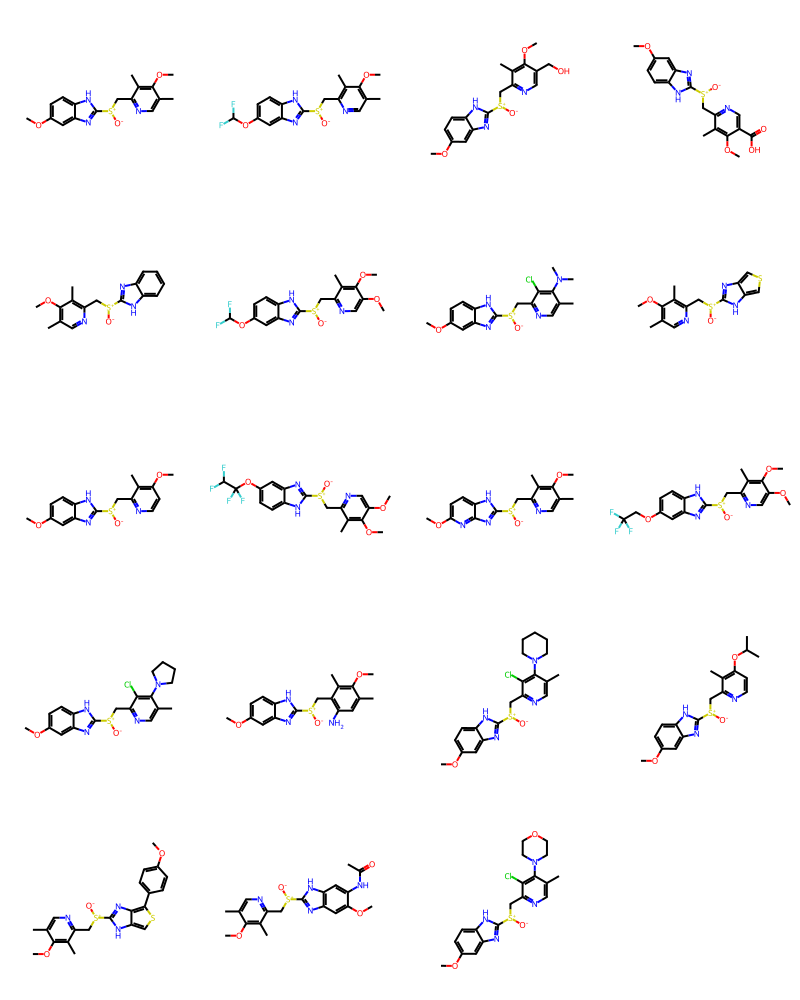

In [6]:
smis = '''COc1ccc2[nH]c([S+]([O-])Cc3ncc(C)c(OC)c3C)nc2c1
COc1c(C)cnc(C[S+]([O-])c2nc3cc(OC(F)F)ccc3[nH]2)c1C
COc1ccc2[nH]c([S+]([O-])Cc3ncc(CO)c(OC)c3C)nc2c1
COc1ccc2[nH]c([S+]([O-])Cc3ncc(C(=O)O)c(OC)c3C)nc2c1
COc1c(C)cnc(C[S+]([O-])c2nc3ccccc3[nH]2)c1C
COc1cnc(C[S+]([O-])c2nc3cc(OC(F)F)ccc3[nH]2)c(C)c1OC
COc1ccc2[nH]c([S+]([O-])Cc3ncc(C)c(N(C)C)c3Cl)nc2c1
COc1c(C)cnc(C[S+]([O-])c2nc3cscc3[nH]2)c1C
COc1ccc2[nH]c([S+]([O-])Cc3nccc(OC)c3C)nc2c1
COc1cnc(C[S+]([O-])c2nc3cc(OC(F)(F)C(F)F)ccc3[nH]2)c(C)c1OC
COc1ccc2[nH]c([S+]([O-])Cc3ncc(C)c(OC)c3C)nc2n1
COc1cnc(C[S+]([O-])c2nc3cc(OCC(F)(F)F)ccc3[nH]2)c(C)c1OC
COc1ccc2[nH]c([S+]([O-])Cc3ncc(C)c(N4CCCC4)c3Cl)nc2c1
COc1ccc2[nH]c([S+]([O-])Cc3c(N)cc(C)c(OC)c3C)nc2c1
COc1ccc2[nH]c([S+]([O-])Cc3ncc(C)c(N4CCCCC4)c3Cl)nc2c1
COc1ccc2[nH]c([S+]([O-])Cc3nccc(OC(C)C)c3C)nc2c1
COc1ccc(-c2scc3[nH]c([S+]([O-])Cc4ncc(C)c(OC)c4C)nc23)cc1
COc1cc2nc([S+]([O-])Cc3ncc(C)c(OC)c3C)[nH]c2cc1NC(C)=O
COc1ccc2[nH]c([S+]([O-])Cc3ncc(C)c(N4CCOCC4)c3Cl)nc2c1'''.split('\n')
mols = [Chem.MolFromSmiles(smi) for smi in smis]
Draw.MolsToGridImage(mols,molsPerRow=4)

Fragment all the molecules and keep the unique fragments:

In [7]:
allfrags=set()
for m in mols:
    pieces = BRICS.BRICSDecompose(m)
    allfrags.update(pieces)
allfrags

{'[1*]C(C)=O',
 '[14*]c1ncc(C)c([16*])c1C',
 '[14*]c1ncc(C)c([16*])c1Cl',
 '[14*]c1ncc([16*])c([16*])c1C',
 '[14*]c1nccc([16*])c1C',
 '[16*]c1c(C)cc(N)c([16*])c1C',
 '[16*]c1ccc([16*])cc1',
 '[3*]OC',
 '[3*]OC(F)F',
 '[3*]O[3*]',
 '[4*]C(C)C',
 '[4*]C(F)(F)C(F)F',
 '[4*]CC(F)(F)F',
 '[5*]N(C)C',
 '[5*]N1CCCC1',
 '[5*]N1CCCCC1',
 '[5*]N1CCOCC1',
 '[5*]N[5*]',
 '[6*]C(=O)O',
 '[8*]CO',
 '[8*]C[S+]([O-])c1nc2c([14*])scc2[nH]1',
 '[8*]C[S+]([O-])c1nc2cc([16*])c([16*])cc2[nH]1',
 '[8*]C[S+]([O-])c1nc2cc([16*])ccc2[nH]1',
 '[8*]C[S+]([O-])c1nc2ccccc2[nH]1',
 '[8*]C[S+]([O-])c1nc2cscc2[nH]1',
 '[8*]C[S+]([O-])c1nc2nc([14*])ccc2[nH]1'}

We can then recombine fragments to produce new molecules using `BRICS.BRICSBuild`:

In [19]:
import random
random.seed(27)

fragms = [Chem.MolFromSmiles(x) for x in allfrags]
builder = BRICS.BRICSBuild(fragms)

The result is a generator:

In [20]:
builder

<generator object BRICSBuild at 0x785401fb8040>

Here's what the first 16 results look like:

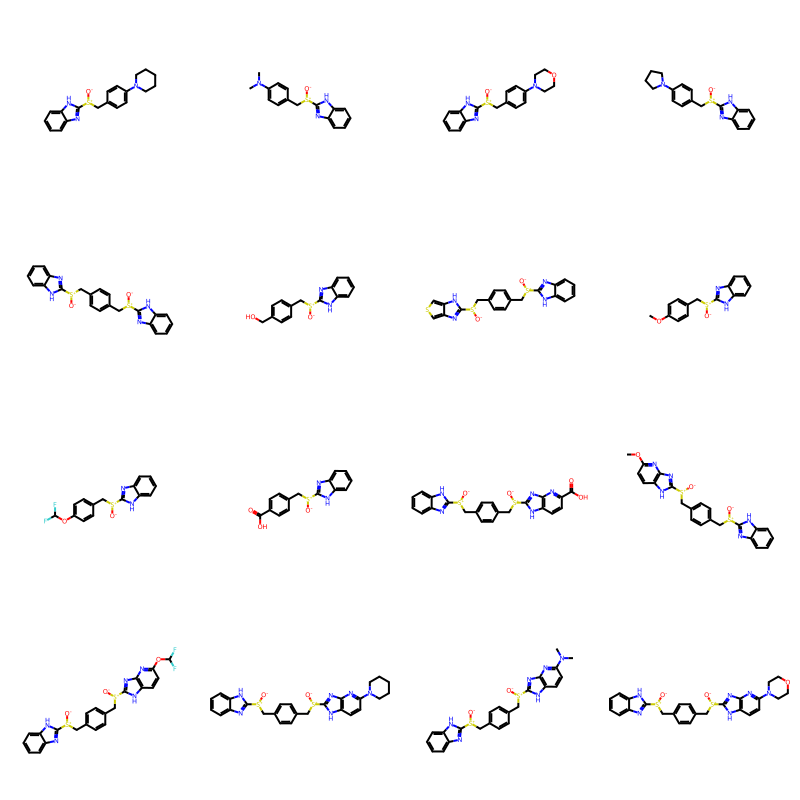

In [21]:
newMols = [next(builder) for i in range(16)]
Draw.MolsToGridImage(newMols,molsPerRow=4)

Let's filter out the everything that doesn't have exactly one sulfoxide:

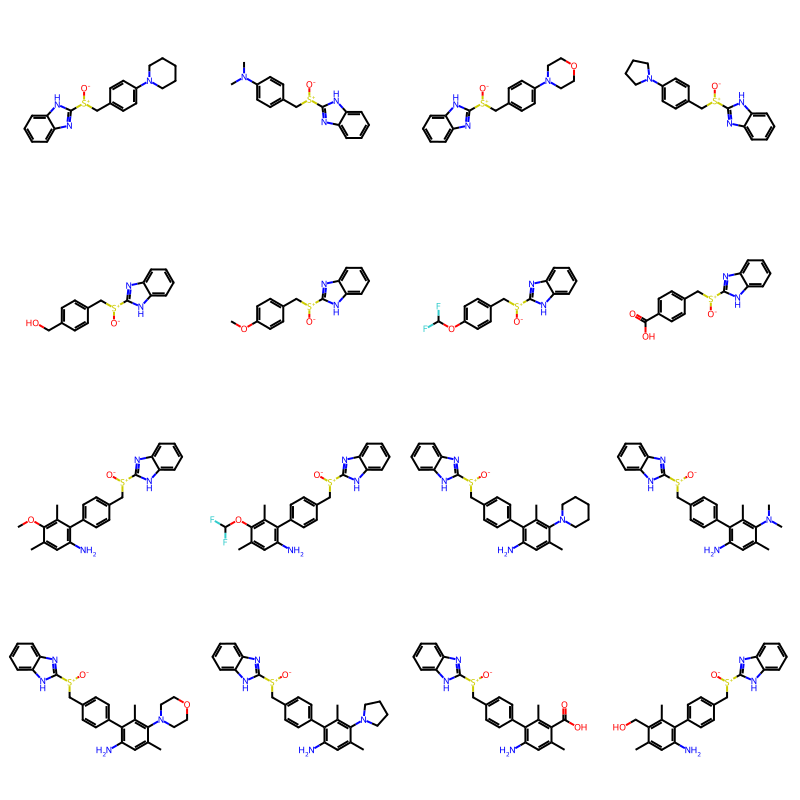

In [23]:
qry = Chem.MolFromSmarts('S-O')
def filter(gen):
    for res in gen:
        if len(res.GetSubstructMatches(qry)) ==1:
            yield res

random.seed(27)
builder = BRICS.BRICSBuild(fragms)
newMols = [next(filter(builder)) for i in range(16)]
Draw.MolsToGridImage(newMols,molsPerRow=4)    

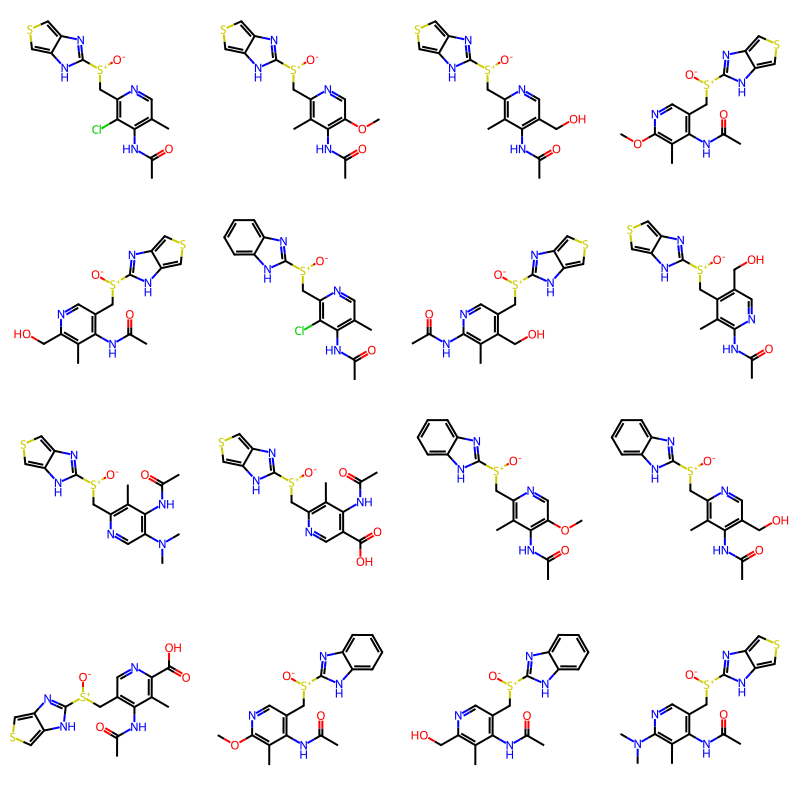

In [24]:
random.seed(42)
builder = BRICS.BRICSBuild(fragms)
newMols = [next(filter(builder)) for i in range(100)]
# order by number of atoms;
newMols = [newMols[y] for (x,y) in sorted([(m.GetNumAtoms(),i) for i,m in enumerate(newMols)])]
Draw.MolsToGridImage(newMols[:16],molsPerRow=4)    

## Providing a seed to the enumeration

Another option in the BRICS builder is to provide one or more seeds that must be present in every output molecule. Here's an example of how to do that using the scaffold of esomeprazole along with a version of the scaffold where the N in the second ring is replaced by a C:


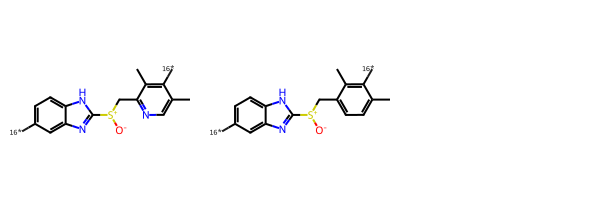

In [14]:
seeds = [Chem.MolFromSmiles(x) for x in ('c19ncc(C)c([16*])c1C.C9[S+]([O-])c1nc2cc([16*])ccc2[nH]1',
                                         'c19ccc(C)c([16*])c1C.C9[S+]([O-])c1nc2cc([16*])ccc2[nH]1',)]

Draw.MolsToGridImage(seeds)

Now do the enumeration using those seeds:

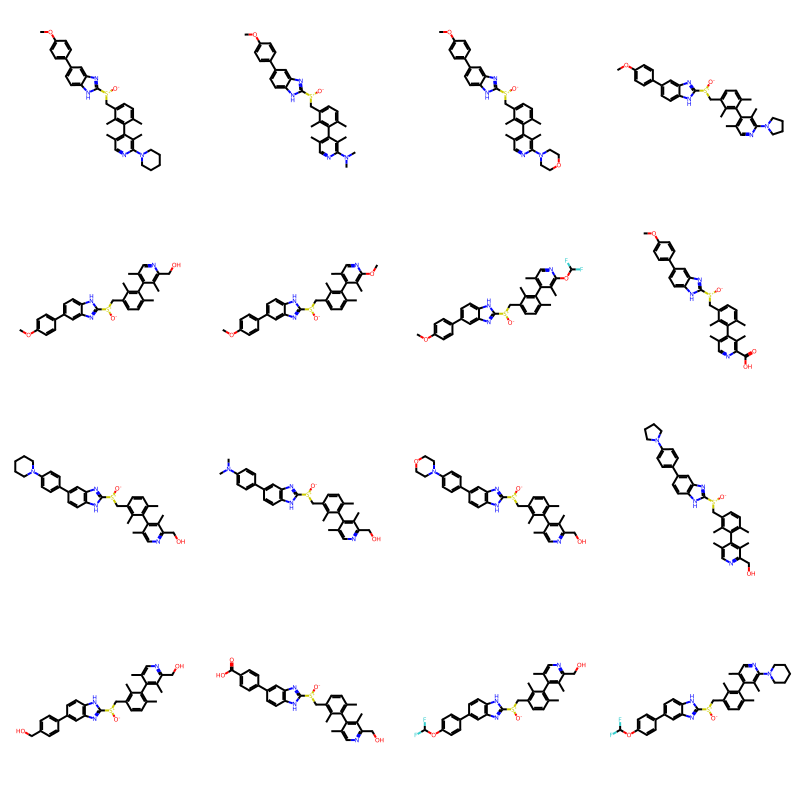

In [15]:
random.seed(127)
builder = BRICS.BRICSBuild(fragms,seeds=seeds)
newMols = [next(filter(builder)) for i in range(16)]
Draw.MolsToGridImage(newMols,molsPerRow=4)    

Doing enumeration providing seeds that are this specific is similar in ways to doing enumeration using the [results of R-group decomposition](https://greglandrum.github.io/rdkit-blog/posts/2022-03-14-rgd-and-molzip.html)